<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_24_CNN_Multi_layer_with_pooling_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_07_24_CNN_Multi_layer_with_pooling_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Multi-Layer With Pooling Prototype

Based on the [CNN Multi-Layer Prototype](https://github.com/sv650s/sb-capstone/blob/master/2019_07_23_CNN_Multi_layer_prototype.ipynb), we run the following variations so we can compare results

Since 3 layer CNN performed slight better in the previous notebook, we will start with that and add:
* max pooling in between all CNN layers
* instead of using early stop, we will run 15 epochs and compare results

We are going to save off the metrics for both models so we can print them out and compare them

As before, I am using some utility functions so I don't have copy so much code around. Source code for the modules are here:
* [dict_util](https://github.com/sv650s/sb-capstone/blob/master/util/dict_util.py)
* [plot_util](https://github.com/sv650s/sb-capstone/blob/master/util/plot_util.py)
* [keras_util](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)
* [file_util](https://github.com/sv650s/sb-capstone/blob/master/util/file_util.py)

In [0]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


import util.file_util as fu
import util.keras_util as ku
import util.plot_util as pu
import util.dict_util as du


%matplotlib inline
sns.set()


import logging
logging.basicConfig(level=logging.INFO)

DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"



Using TensorFlow backend.


In [0]:
# load data file
df = pd.read_csv(f"{DATA_FILE}")

# extract feature and label columns
rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

Same as previous notebooks but consolidated to one cell to make thing easier to understand

Features:
* tokenize our review body - this gives us:
  * vocab size: 40788 words
* then we will pad the sequences to length 186 since this encapsulates 99% of the lenght of our training data

Labels:
* one hot encode our star rating labels (y)


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

# figure out 99% percentile for our max sequence length
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
MAX_SEQUENCE_LENGTH = int(df.review_length.quantile([0.99]).values[0])
print(f'Max Sequence Length: {MAX_SEQUENCE_LENGTH}')

# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


# Build Our 3 Layer Model With Pooling In Between Layers

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [0]:
MODEL_NAME3 = "CNN_3layer_maxpooling_earlystop"
EMBED_SIZE = 300
EPOCHS  = 15
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [0]:
model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(250, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


W0730 06:32:33.598369 140626585520000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 06:32:33.621417 140626585520000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 06:32:33.625489 140626585520000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 06:32:33.667556 140626585520000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0730 06:32:33.759943 140626585520000 deprecation_wrapp

In [0]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 186, 300)          12236700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 100)          90100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 93, 100)           30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 46, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 100)           30100     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 100)           0         
__________

In [0]:
# this is ame as before
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

# use our model wrapper the wrap the model so we can save things for later
mw = ku.ModelWrapper(model=model3, 
                     name=MODEL_NAME3, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE,
                     tokenizer=t,
                     embedding=EMBED_SIZE)

network_history3 = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0730 06:32:33.954223 140626585520000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0730 06:32:34.113301 140626585520000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 67225 samples, validate on 16807 samples
Epoch 1/15
39168/67225 [================>.............] - ETA: 2:25 - loss: 1.0022 - acc: 0.6156

KeyboardInterrupt: ignored

## Get Metrics for our 3 Layer Model with Pooling

In [0]:
# get scores
mw.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (mw.scores3[1]*100))

In [0]:
mw.confusion_matrix

## Save our model

In [0]:
mw.save(DRIVE_DIR, append_report=True)

# Build Our 3 Layer Model With Pooling In Between Layers - Do not use early stop this time

* we will use embedding size of 300 since this gave us slight improvement from previous notebook for class 1 and 2

In [13]:
MODEL_NAME = "CNN_3layer_maxpooling_15epoch"

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# use our model wrapper the wrap the model so we can save things for later
mw15 = ku.ModelWrapper(model=model, 
                     name=MODEL_NAME, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE, 
                     tokenizer=t,
                     embedding=EMBED_SIZE)


network_history = mw15.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2)

Train on 67225 samples, validate on 16807 samples
Epoch 1/15
67225/67225 [==============================] - 360s 5ms/step - loss: 0.9533 - acc: 0.6329 - val_loss: 0.8550 - val_acc: 0.6706
Epoch 2/15
67225/67225 [==============================] - 358s 5ms/step - loss: 0.7483 - acc: 0.7052 - val_loss: 0.8386 - val_acc: 0.6789
Epoch 3/15
67225/67225 [==============================] - 358s 5ms/step - loss: 0.6168 - acc: 0.7587 - val_loss: 0.9314 - val_acc: 0.6698
Epoch 4/15
67225/67225 [==============================] - 357s 5ms/step - loss: 0.4974 - acc: 0.8086 - val_loss: 1.0825 - val_acc: 0.6630
Epoch 5/15
67225/67225 [==============================] - 356s 5ms/step - loss: 0.3935 - acc: 0.8514 - val_loss: 1.2614 - val_acc: 0.6254
Epoch 6/15
67225/67225 [==============================] - 357s 5ms/step - loss: 0.3094 - acc: 0.8862 - val_loss: 1.4171 - val_acc: 0.6407
Epoch 7/15
67225/67225 [==============================] - 354s 5ms/step - loss: 0.2428 - acc: 0.9125 - val_loss: 1.5674 - 

## Get Metrics


In [14]:
# get scores
mw15.evaluate(X_test, y_test, verbose=1)

Running model.evaluate...
28011/28011 [==============================] - 34s 1ms/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


## Save off our model files

In [15]:
mw15.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer_maxpooling_15epoch-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer_maxpooling_15epoch-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-CNN_3layer_maxpooling_15epoch-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-31-dl_protype-report.csv
Saving report file...


# Print metrics for the 2 models and compare


* look at accuracy scores
* epoch vs loss and accuarcy
* confusion matrix
* ROC/AUC plot

In [16]:
print(f"Accuracy - {mw.name}: %.2f%%" % (mw.scores[1]*100))
print(f"Accuracy - {mw15.name}: %.2f%%" % (mw15.scores[1]*100))

Accuracy - CNN_3layer_maxpooling_earlystop: 67.58%
Accuracy - CNN_3layer_maxpooling_15epoch: 59.59%


CNN_3layer_maxpooling_earlystop


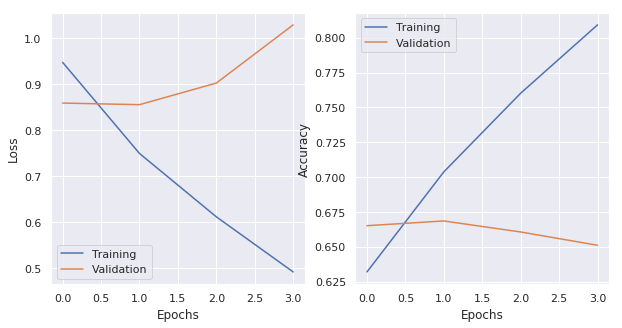

In [17]:
print(mw.name)
pu.plot_network_history(mw.network_history)

CNN_3layer_maxpooling_15epoch


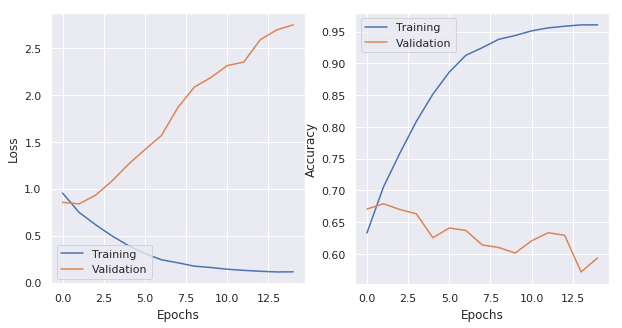

In [18]:
print(mw15.name)
pu.plot_network_history(mw15.network_history)

In [19]:
print(f"Confusion matrix - {mw.name}")
print(mw.confusion_matrix)

Confusion matrix - CNN_3layer_maxpooling_earlystop
[[ 3506    48   160    58   196]
 [ 1174    84   274   138   201]
 [  739   110   631   520   531]
 [  276    40   402  1235  2799]
 [  341    12   201   861 13474]]


In [20]:
print(f"Confusion matrix - {mw15.name}")
print(mw15.confusion_matrix)

Confusion matrix - CNN_3layer_maxpooling_15epoch
[[ 2067  1060   480   152   209]
 [  409   541   513   231   177]
 [  178   425   787   736   405]
 [   60   149   529  1901  2113]
 [  111   149   440  2793 11396]]


### Confusion Matrix Analysis

With the exception of class 1 and 5, with 15 epochs we correctly identified rating 2, 3, 4 more than early stop model. However, we also mis-classified a lot more in those classes as this model is less likely to classify something as 1 or 5

In [21]:
print(f"Classification Report - {mw.name}")
print(mw.classification_report)

Classification Report - CNN_3layer_maxpooling_earlystop
              precision    recall  f1-score   support

           1       0.58      0.88      0.70      3968
           2       0.29      0.04      0.08      1871
           3       0.38      0.25      0.30      2531
           4       0.44      0.26      0.33      4752
           5       0.78      0.90      0.84     14889

    accuracy                           0.68     28011
   macro avg       0.49      0.47      0.45     28011
weighted avg       0.63      0.68      0.63     28011



In [22]:
print(f"Classification Report - {mw15.name}")
print(mw15.classification_report)

Classification Report - CNN_3layer_maxpooling_15epoch
              precision    recall  f1-score   support

           1       0.73      0.52      0.61      3968
           2       0.23      0.29      0.26      1871
           3       0.29      0.31      0.30      2531
           4       0.33      0.40      0.36      4752
           5       0.80      0.77      0.78     14889

    accuracy                           0.60     28011
   macro avg       0.47      0.46      0.46     28011
weighted avg       0.62      0.60      0.61     28011



### Classification Report Analysis

Recall increased for the 15 epoch model for star ratings 3, 4, 5 but decreased for ratings 1 and 5. Precision actually increased for ratings 1 and 5 in the 15 epoch model however, for the other classes this actually decreased even though recall inreased

Overall, 15 epoch model, is less likely to classify something as rating 1 or 5, however, when it does, it tends to be more accurate than the early stop model. However, early stop model was less likely to classify something as rating 2, 3, or 4. However, when it does, there tends to be higher likelihodd that it is correctly clssified.


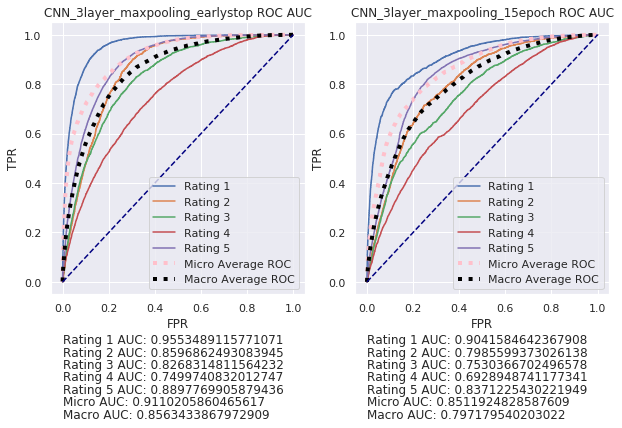

In [23]:

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, figure=fig)
fig.add_subplot(gs[0, 0])
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

fig.add_subplot(gs[0, 1])
pu.plot_roc_auc(mw15.name, mw15.roc_auc, mw15.fpr, mw15.tpr)


### AUC analysis

AUC for all classes decreased without early stopping. Both Micro and Macro average AUC decreased as well

# Summary

Overall, early stopping performed better than the model without early stopping

In almost all classes, recall was higher for 15 epochs vs early stopping, however, that is at the expense of precision meaning that we can trust the prediction less.

The only exception here was Rating 1 which the 15 epoch model actually was less likely to classify something into this category (ie, recall decreased) but the precission of the model actually went up from 59% to 73%

When you look at our problem clssess - star rating 2 and 4 - both exhibited the same behavior - recall went up and precision went down. When you look at ROC/AUC, you can see that the AUC for all classes decreased for the 15 epoch model meaning that as we traing the dataset with more epochs, the discernability between classes decreased.

Overall, because of this I would choose the early stopping model.

